In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Clustering Analysis from DataDumper

Perform clustering on vehicle telematics data to identify driving patterns and operational characteristics.

In [2]:
# Load data
df = pd.read_parquet('dataDumper.parquet')
print(f"Data shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Data shape: (201312, 33)

Columns: ['Time_utc', 'VehicleName', 'VehicleType', 'Pressure_Pa_1', 'Pressure_Pa_2', 'Pressure_Pa_3', 'Pressure_Pa_4', 'Pressure_Pa_5', 'Pressure_Pa_6', 'Temperature_K_1', 'Temperature_K_2', 'Temperature_K_3', 'Temperature_K_4', 'Temperature_K_5', 'Temperature_K_6', 'ColdPressure_Pa_1', 'ColdPressure_Pa_2', 'ColdPressure_Pa_3', 'ColdPressure_Pa_4', 'ColdPressure_Pa_5', 'ColdPressure_Pa_6', 'Latitude_dd', 'Longitude_dd', 'Altitude_m', 'Speed_mps', 'epsilonX', 'epsilonY', 'epsilonZ', 'epsilonSpeed', 'AtmosphericPressure_Pa', 'dt_s', 'dd_m', 'RatioPayload']


## 1. Data Preparation for Clustering

In [3]:
# Select features for clustering (exclude time and location)
# Focus on tire conditions, operational parameters, and performance metrics
feature_cols = [
    'Pressure_Pa_1', 'Pressure_Pa_2', 'Pressure_Pa_3', 'Pressure_Pa_4', 'Pressure_Pa_5', 'Pressure_Pa_6',
    'Temperature_K_1', 'Temperature_K_2', 'Temperature_K_3', 'Temperature_K_4', 'Temperature_K_5', 'Temperature_K_6',
    'ColdPressure_Pa_1', 'ColdPressure_Pa_2', 'ColdPressure_Pa_3', 'ColdPressure_Pa_4', 'ColdPressure_Pa_5', 'ColdPressure_Pa_6',
    'Speed_mps', 'Altitude_m', 'AtmosphericPressure_Pa', 'RatioPayload'
]

# Create feature matrix
X = df[feature_cols].copy()

# Handle missing values
print(f"Missing values:\n{X.isna().sum().sum()}")
X = X.fillna(X.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features for clustering: {len(feature_cols)}")
print(f"Samples: {X_scaled.shape[0]}")

Missing values:
12680
Features for clustering: 22
Samples: 201312


## 2. Determine Optimal Number of Clusters (Elbow Method)

In [ ]:
# Calculate inertia and silhouette scores for different k values
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    print(f"Clustering with k={k}")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette plot
ax2.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score by Number of Clusters', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k (highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (by silhouette score): {optimal_k}")

Clustering with k=2


## 3. Apply K-Means Clustering

In [4]:
optimal_k = 2

In [5]:
# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['cluster'] = clusters

print(f"Clustering complete!")
print(f"\nCluster distribution:")
print(df['cluster'].value_counts().sort_index())
print(f"\nSilhouette Score: {silhouette_score(X_scaled, clusters):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, clusters):.4f}")

Clustering complete!

Cluster distribution:
cluster
0     51066
1    150246
Name: count, dtype: int64

Silhouette Score: 0.3546
Davies-Bouldin Index: 1.2515


## 4. Visualize Clusters with PCA

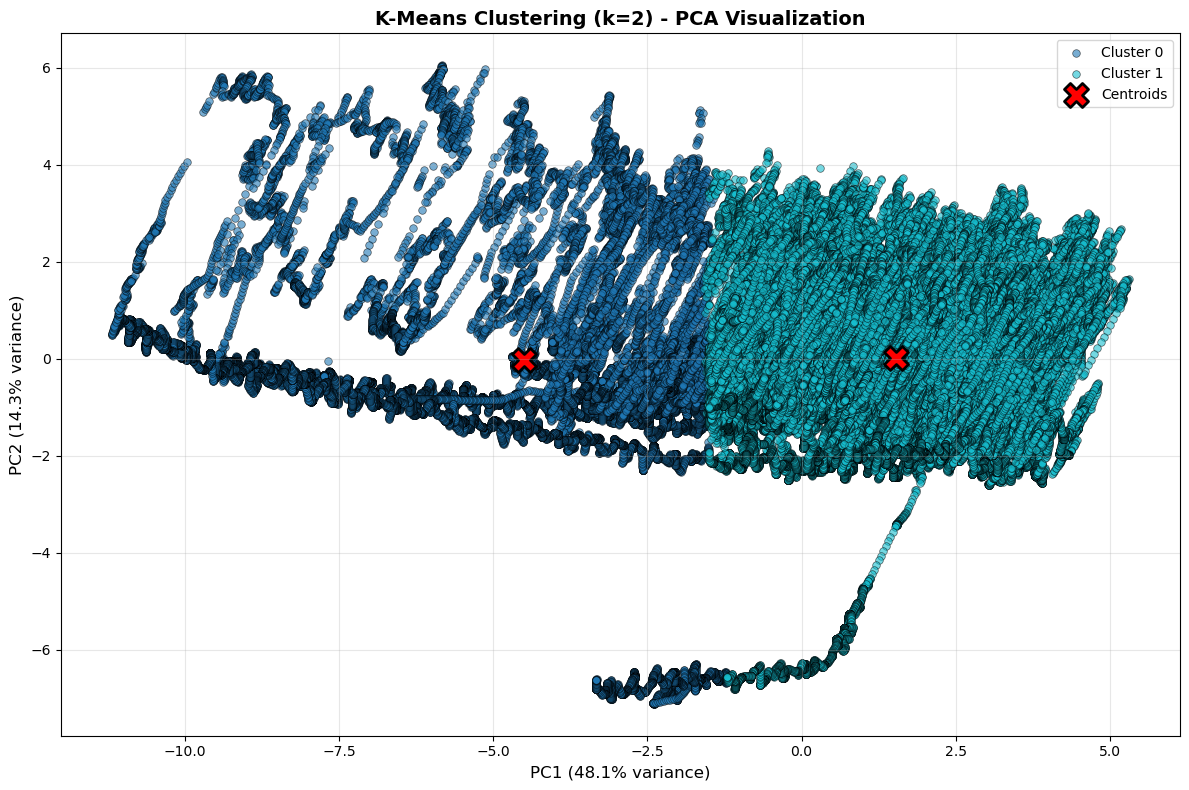

PCA explains 62.38% of variance


In [26]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters in PCA space
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    mask = clusters == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=[colors[i]], label=f'Cluster {i}', 
                alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

# Plot cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
            c='red', marker='X', s=300, edgecolors='black', linewidth=2,
            label='Centroids')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title(f'K-Means Clustering (k={optimal_k}) - PCA Visualization', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PCA explains {pca.explained_variance_ratio_.sum():.2%} of variance")

Most explicative features for PC1:
  Pressure_Pa_5: 0.3043 (loading)
  Pressure_Pa_3: 0.3027 (loading)
  Temperature_K_2: 0.2991 (loading)
  Temperature_K_4: 0.2990 (loading)
  Temperature_K_5: 0.2980 (loading)

Most explicative features for PC2:
  ColdPressure_Pa_5: 0.4698 (loading)
  ColdPressure_Pa_3: 0.4194 (loading)
  RatioPayload: 0.4151 (loading)
  ColdPressure_Pa_6: 0.3299 (loading)
  Pressure_Pa_6: 0.2733 (loading)


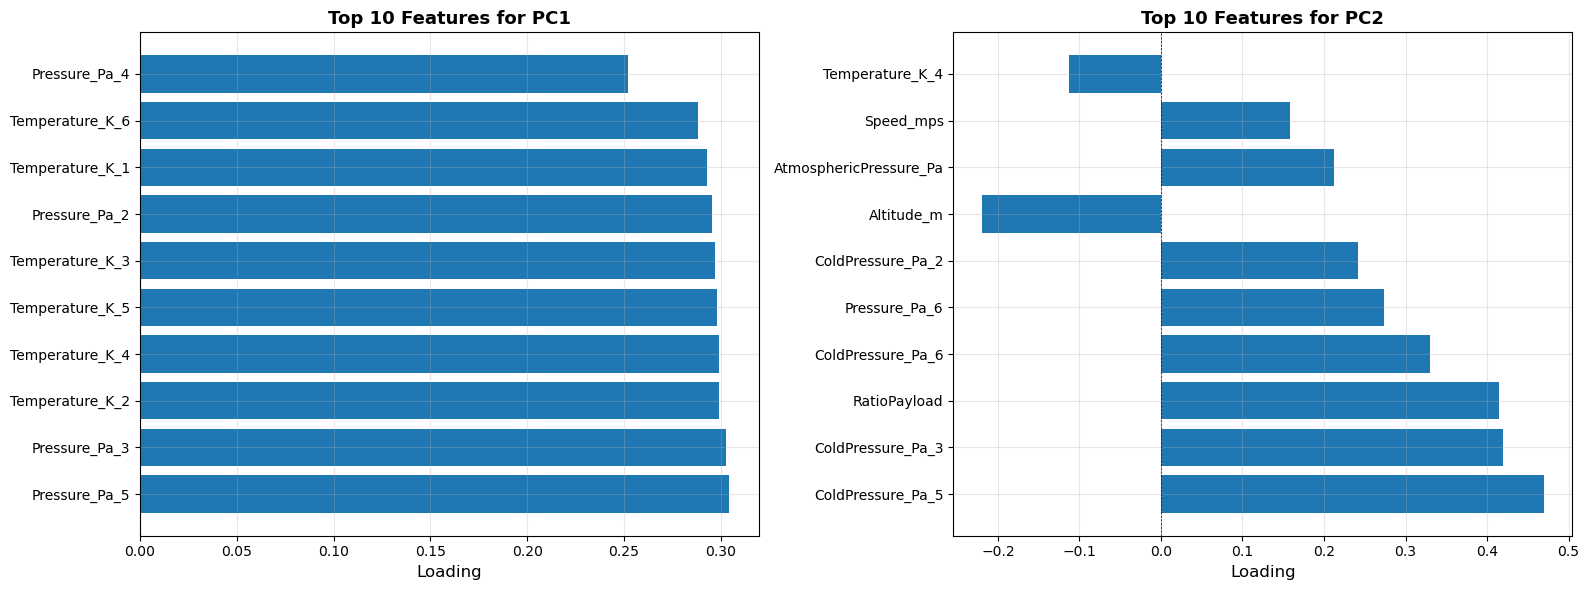

In [27]:
# Find the most explicative variables for PC1 and PC2
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_cols
)

# Get absolute values for ranking importance
components_abs = components_df.abs()

# Top features for PC1
print("Most explicative features for PC1:")
pc1_top = components_abs['PC1'].sort_values(ascending=False).head(5)
for feature, loading in pc1_top.items():
    print(f"  {feature}: {components_df.loc[feature, 'PC1']:.4f} (loading)")

print("\nMost explicative features for PC2:")
pc2_top = components_abs['PC2'].sort_values(ascending=False).head(5)
for feature, loading in pc2_top.items():
    print(f"  {feature}: {components_df.loc[feature, 'PC2']:.4f} (loading)")

# Visualize feature contributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# PC1 loadings
top_10_pc1 = components_abs['PC1'].sort_values(ascending=False).head(10)
ax1.barh(range(len(top_10_pc1)), [components_df.loc[f, 'PC1'] for f in top_10_pc1.index])
ax1.set_yticks(range(len(top_10_pc1)))
ax1.set_yticklabels(top_10_pc1.index)
ax1.set_xlabel('Loading', fontsize=12)
ax1.set_title('Top 10 Features for PC1', fontsize=13, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
ax1.grid(True, alpha=0.3)

# PC2 loadings
top_10_pc2 = components_abs['PC2'].sort_values(ascending=False).head(10)
ax2.barh(range(len(top_10_pc2)), [components_df.loc[f, 'PC2'] for f in top_10_pc2.index])
ax2.set_yticks(range(len(top_10_pc2)))
ax2.set_yticklabels(top_10_pc2.index)
ax2.set_xlabel('Loading', fontsize=12)
ax2.set_title('Top 10 Features for PC2', fontsize=13, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Cluster Characteristics Analysis

Cluster Characteristics (All Variables):
 Cluster   Size  Avg_Pressure_Pa_1  Avg_Pressure_Pa_2  Avg_Pressure_Pa_3  Avg_Pressure_Pa_4  Avg_Pressure_Pa_5  Avg_Pressure_Pa_6  Avg_Temperature_K_1  Avg_Temperature_K_2  Avg_Temperature_K_3  Avg_Temperature_K_4  Avg_Temperature_K_5  Avg_Temperature_K_6  Avg_ColdPressure_Pa_1  Avg_ColdPressure_Pa_2  Avg_ColdPressure_Pa_3  Avg_ColdPressure_Pa_4  Avg_ColdPressure_Pa_5  Avg_ColdPressure_Pa_6  Avg_Latitude_dd  Avg_Longitude_dd  Avg_Altitude_m  Avg_Speed_mps  Avg_epsilonX  Avg_epsilonY  Avg_epsilonZ  Avg_epsilonSpeed  Avg_AtmosphericPressure_Pa     Avg_dt_s  Avg_dd_m  Avg_RatioPayload
       0  51066      923139.040915      914863.956577      786718.828281      731495.997316      759776.319309      766175.822217           317.435452           313.783668           317.868488           319.728562           315.765433           313.880364          838223.967946          841203.648899          711774.946407          656955.916758          692379.490027

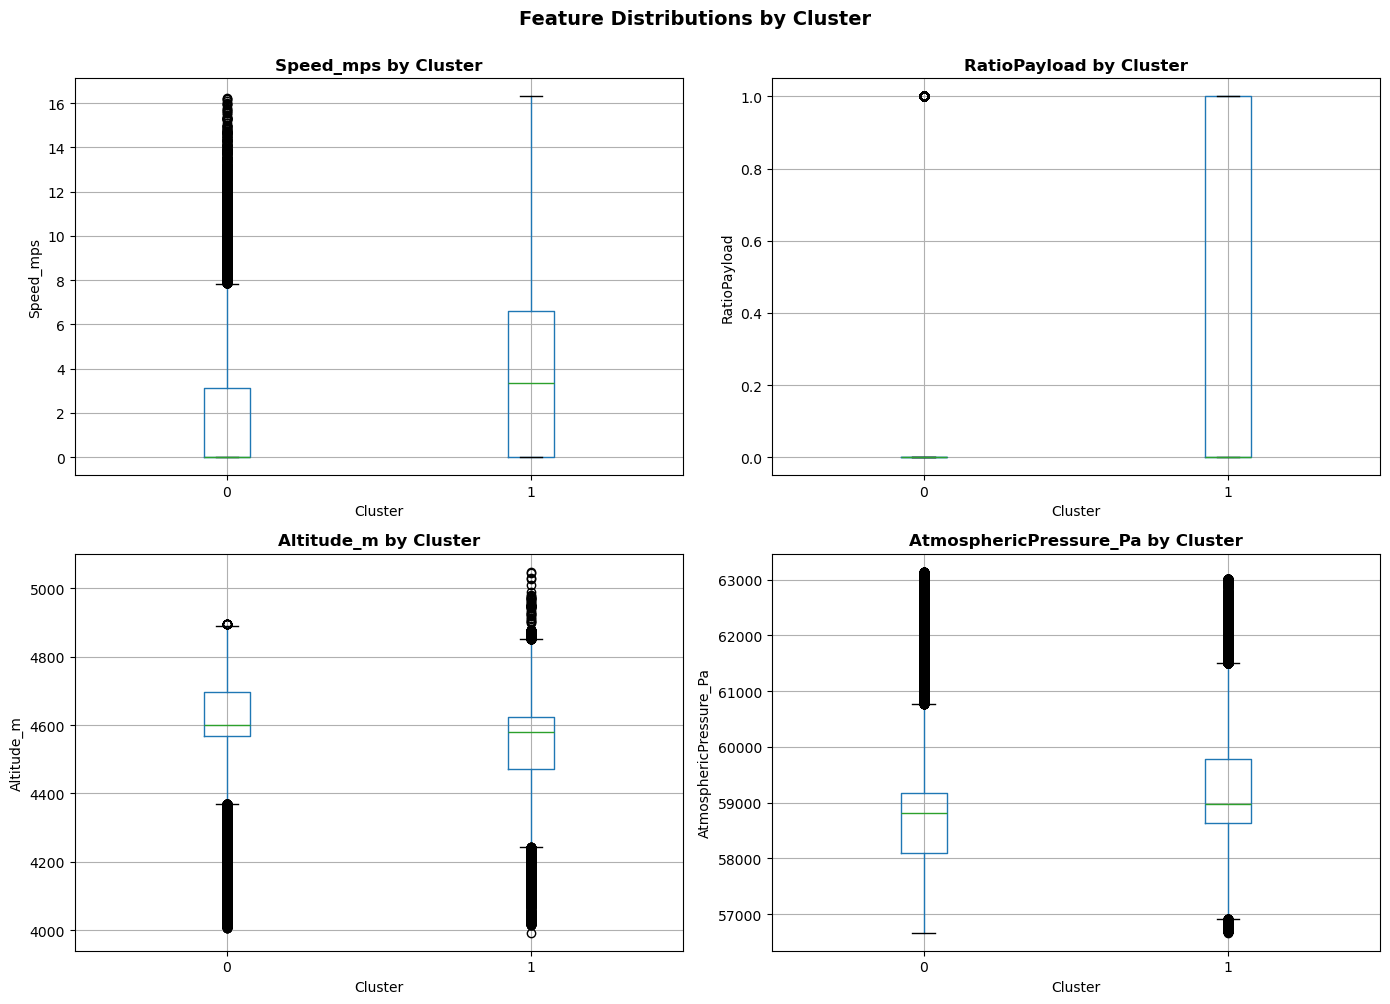

In [31]:
# Analyze cluster characteristics - compute mean for all variables
cluster_stats = pd.DataFrame()

for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    
    # Start with Cluster and Size
    stats = {
        'Cluster': cluster_id,
        'Size': len(cluster_data),
    }
    
    # Add mean for all numeric columns (excluding cluster label itself)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col != 'cluster':
            stats[f'Avg_{col}'] = cluster_data[col].mean()
    
    cluster_stats = pd.concat([cluster_stats, pd.DataFrame([stats])], ignore_index=True)

print("Cluster Characteristics (All Variables):")
print(cluster_stats.to_string(index=False))
print(f"\n")

# Box plots for key features by cluster
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features_to_plot = [
    'Speed_mps',
    'RatioPayload',
    'Altitude_m',
    'AtmosphericPressure_Pa'
]

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 2, idx % 2]
    df.boxplot(column=feature, by='cluster', ax=ax)
    ax.set_title(f'{feature} by Cluster', fontweight='bold')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

plt.suptitle('Feature Distributions by Cluster', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 6. Save Clustered Data

In [32]:
# Save clustered data
df.to_parquet('dataDumper_clustered.parquet', index=False)
cluster_stats.to_csv('cluster_statistics.csv', index=False)

print("Clustered data saved!")
print("- dataDumper_clustered.parquet (original data with cluster labels)")
print("- cluster_statistics.csv (cluster summary statistics)")

Clustered data saved!
- dataDumper_clustered.parquet (original data with cluster labels)
- cluster_statistics.csv (cluster summary statistics)


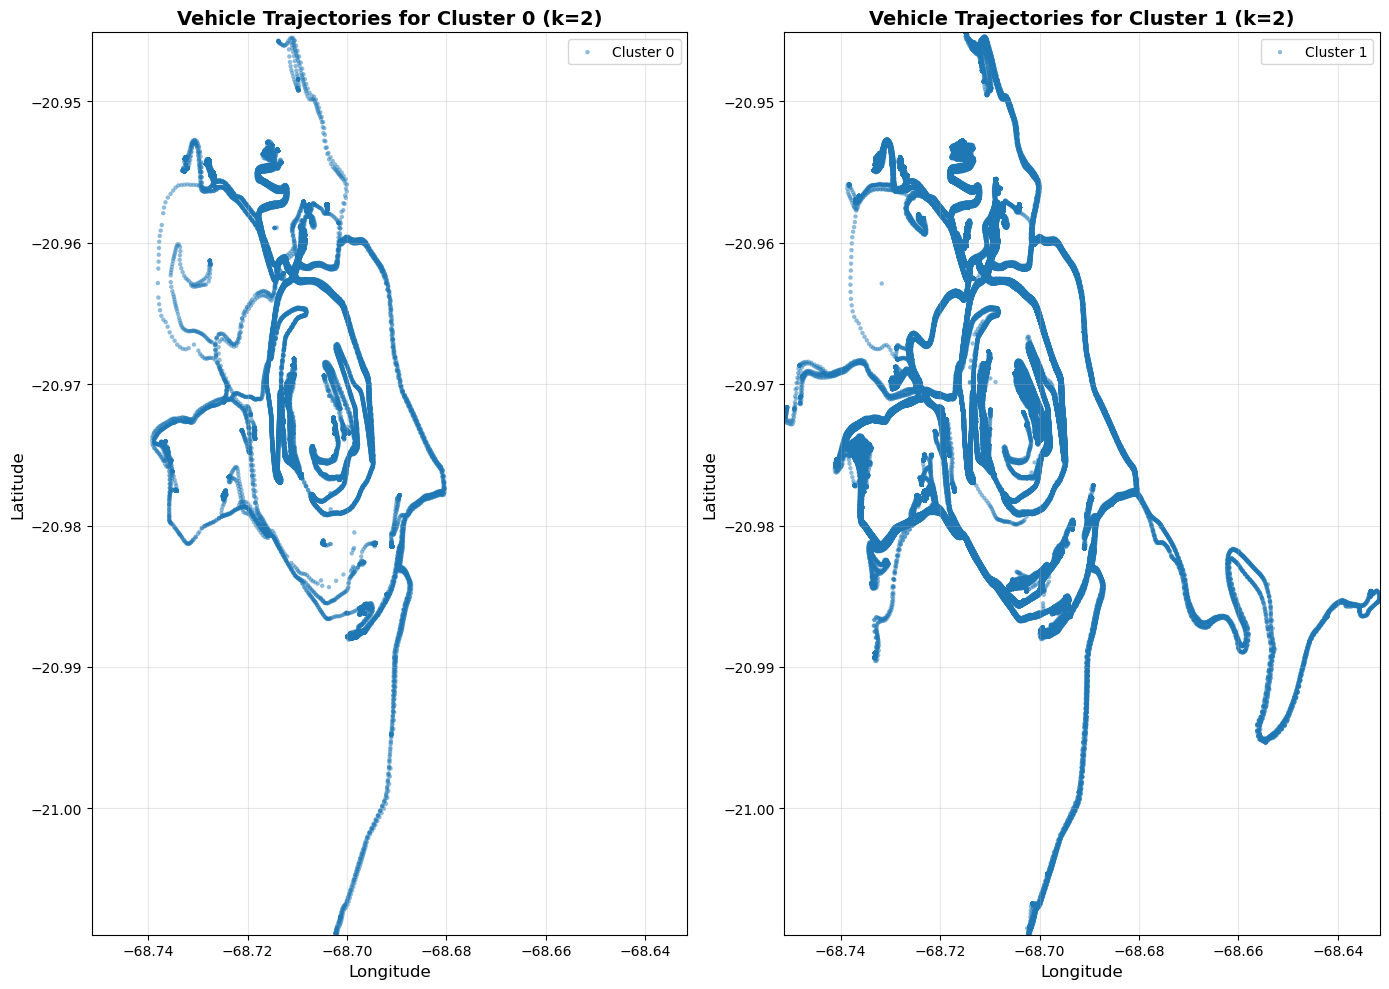

In [30]:
# Plot trajectories colored by cluster
# Find global min/max for both axes to make them consistent across subplots
global_lon_min = df['Longitude_dd'].min()
global_lon_max = df['Longitude_dd'].max()
global_lat_min = df['Latitude_dd'].min()
global_lat_max = df['Latitude_dd'].max()

plt.figure(figsize=(14, 10))

for cluster_id in range(optimal_k):
    plt.subplot(1, optimal_k, cluster_id + 1)
    cluster_data = df[df['cluster'] == cluster_id]
    plt.scatter(cluster_data['Longitude_dd'], cluster_data['Latitude_dd'], 
                label=f'Cluster {cluster_id}', 
                alpha=0.5, s=10, edgecolors='none')

    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title(f'Vehicle Trajectories for Cluster {cluster_id} (k={optimal_k})', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Set same axis limits for all subplots
    plt.xlim(global_lon_min, global_lon_max)
    plt.ylim(global_lat_min, global_lat_max)

plt.tight_layout()
plt.show()

## 7. Cluster Differences Analysis

In [ ]:
# Cluster 1 faster but also more loaded

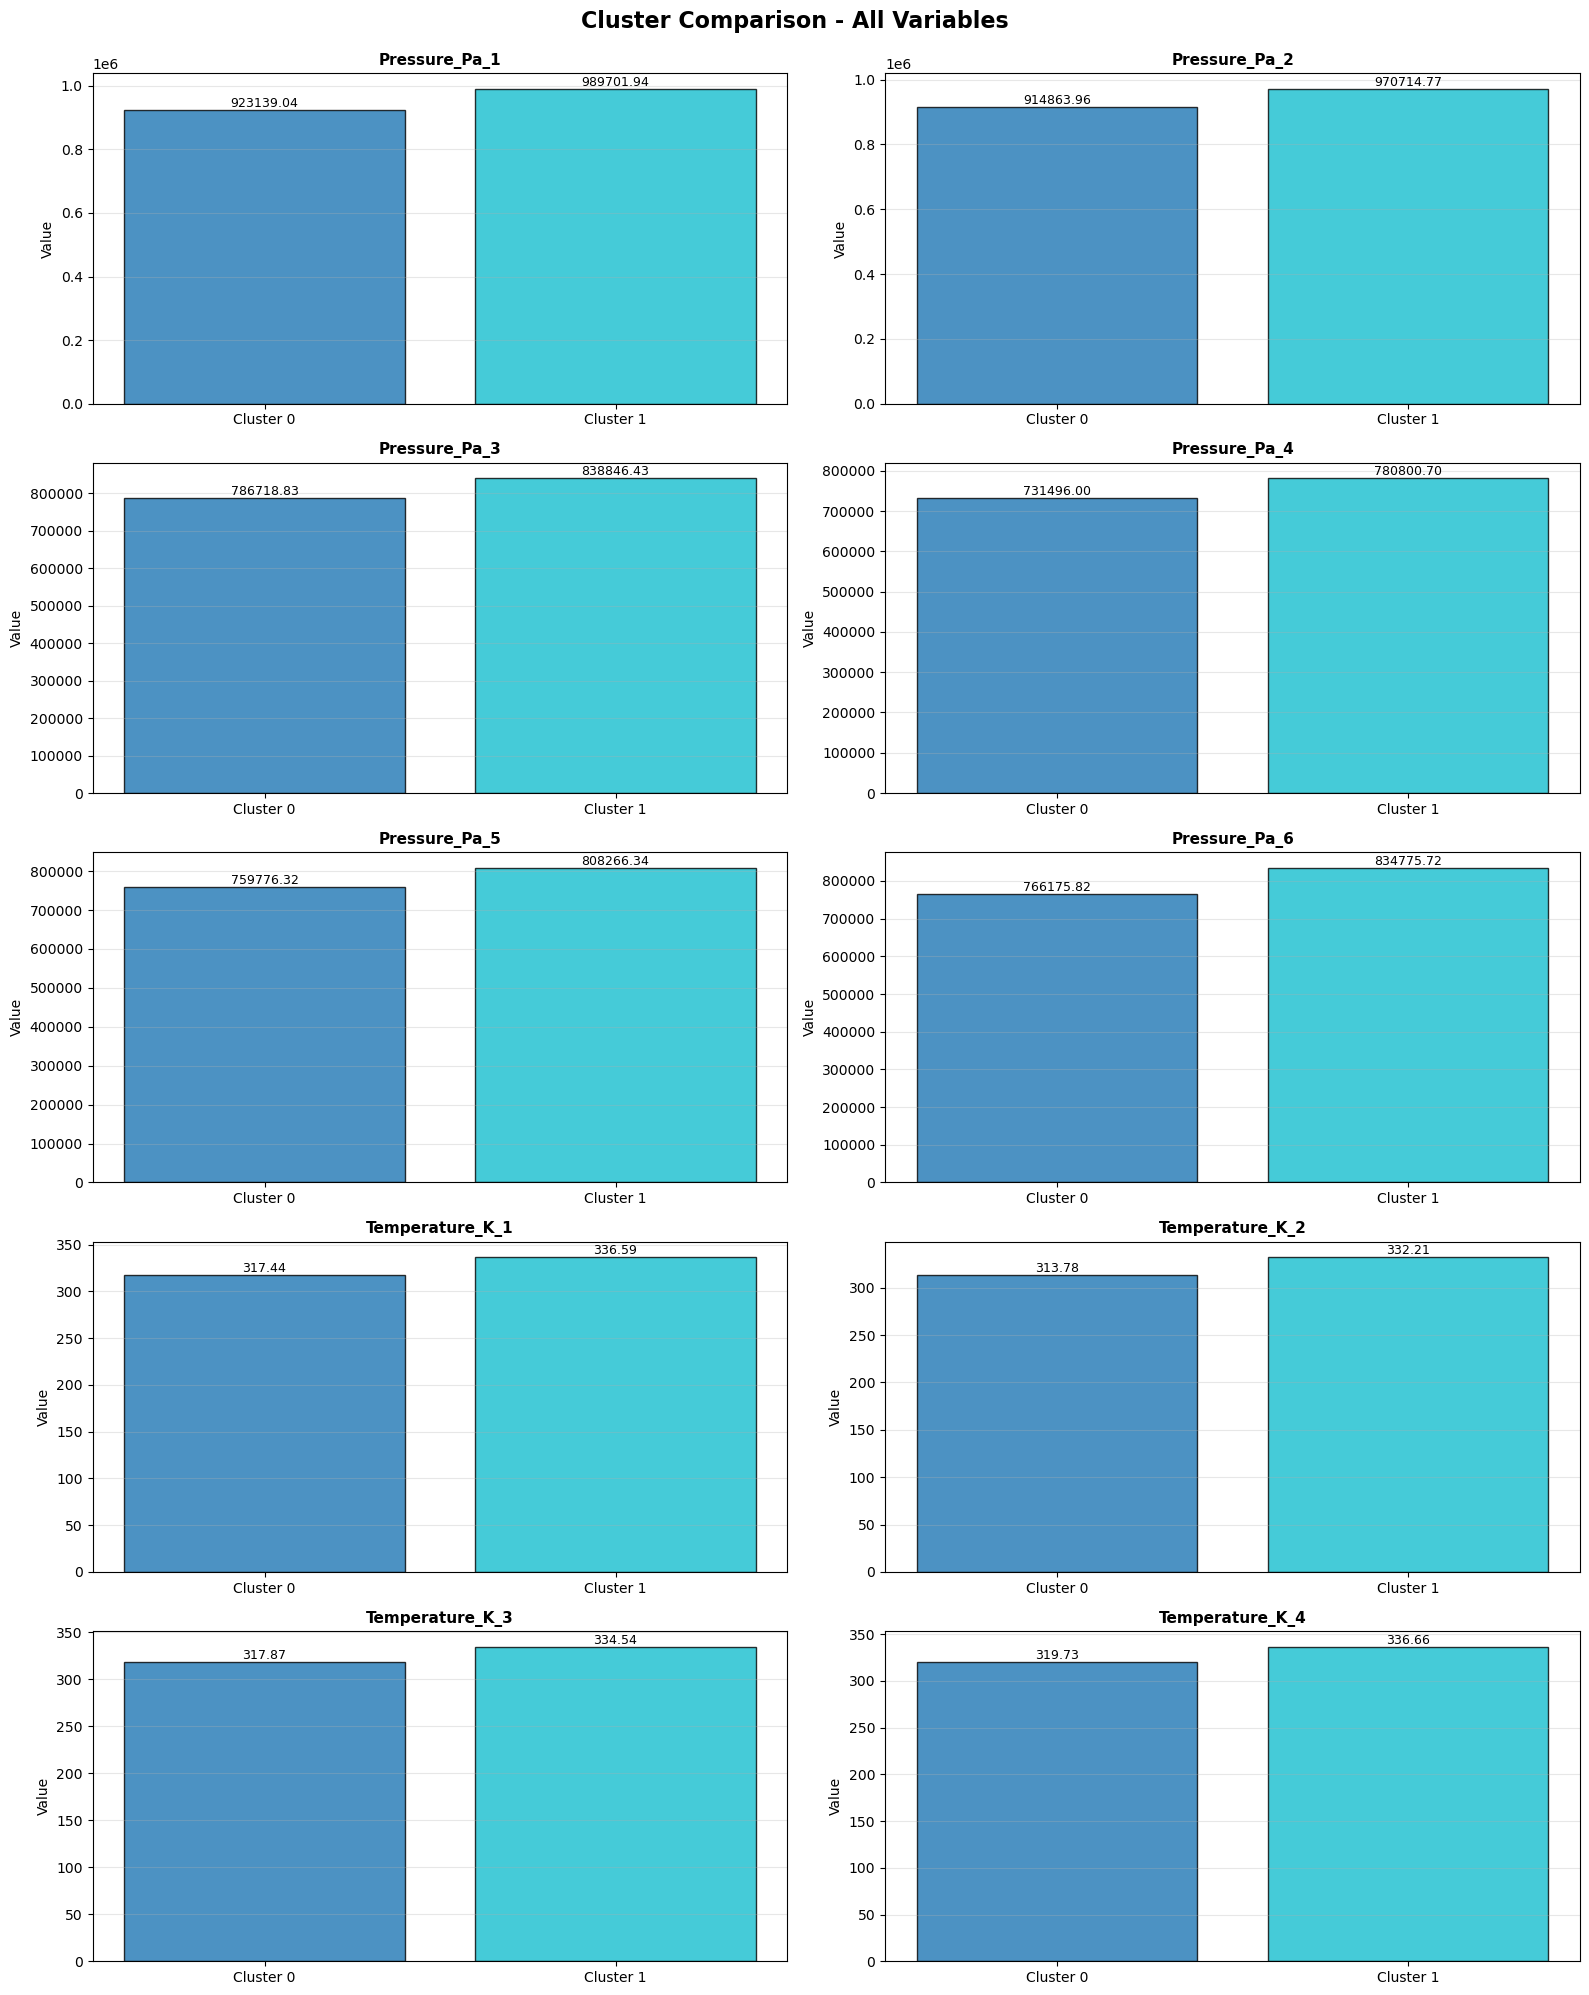

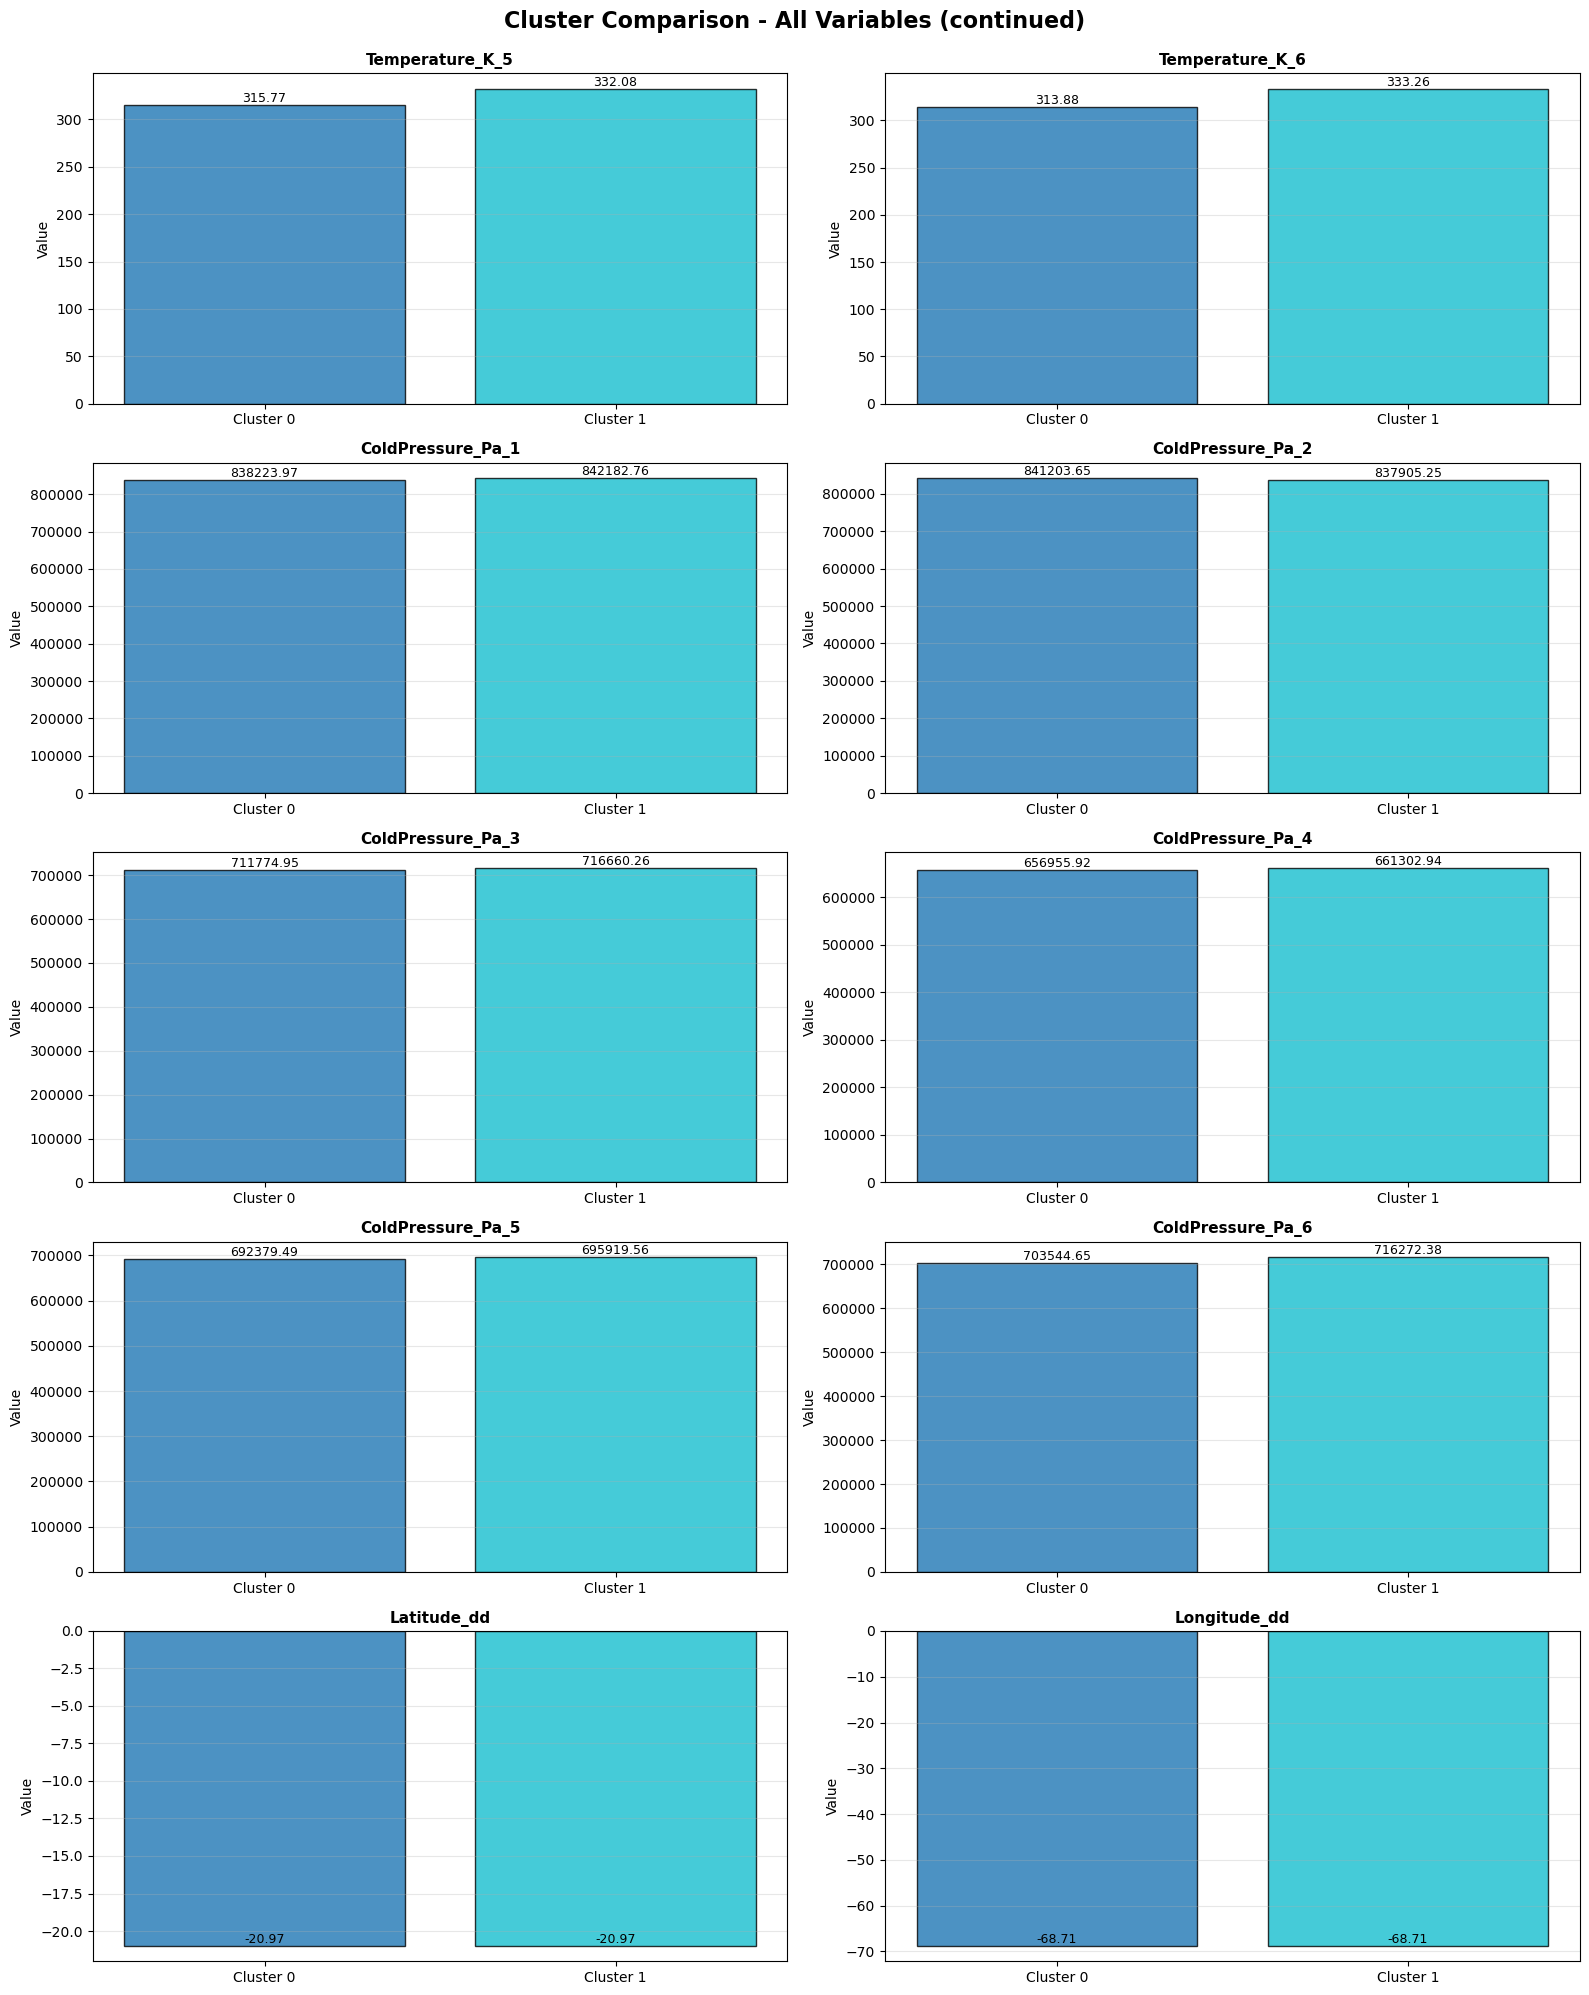

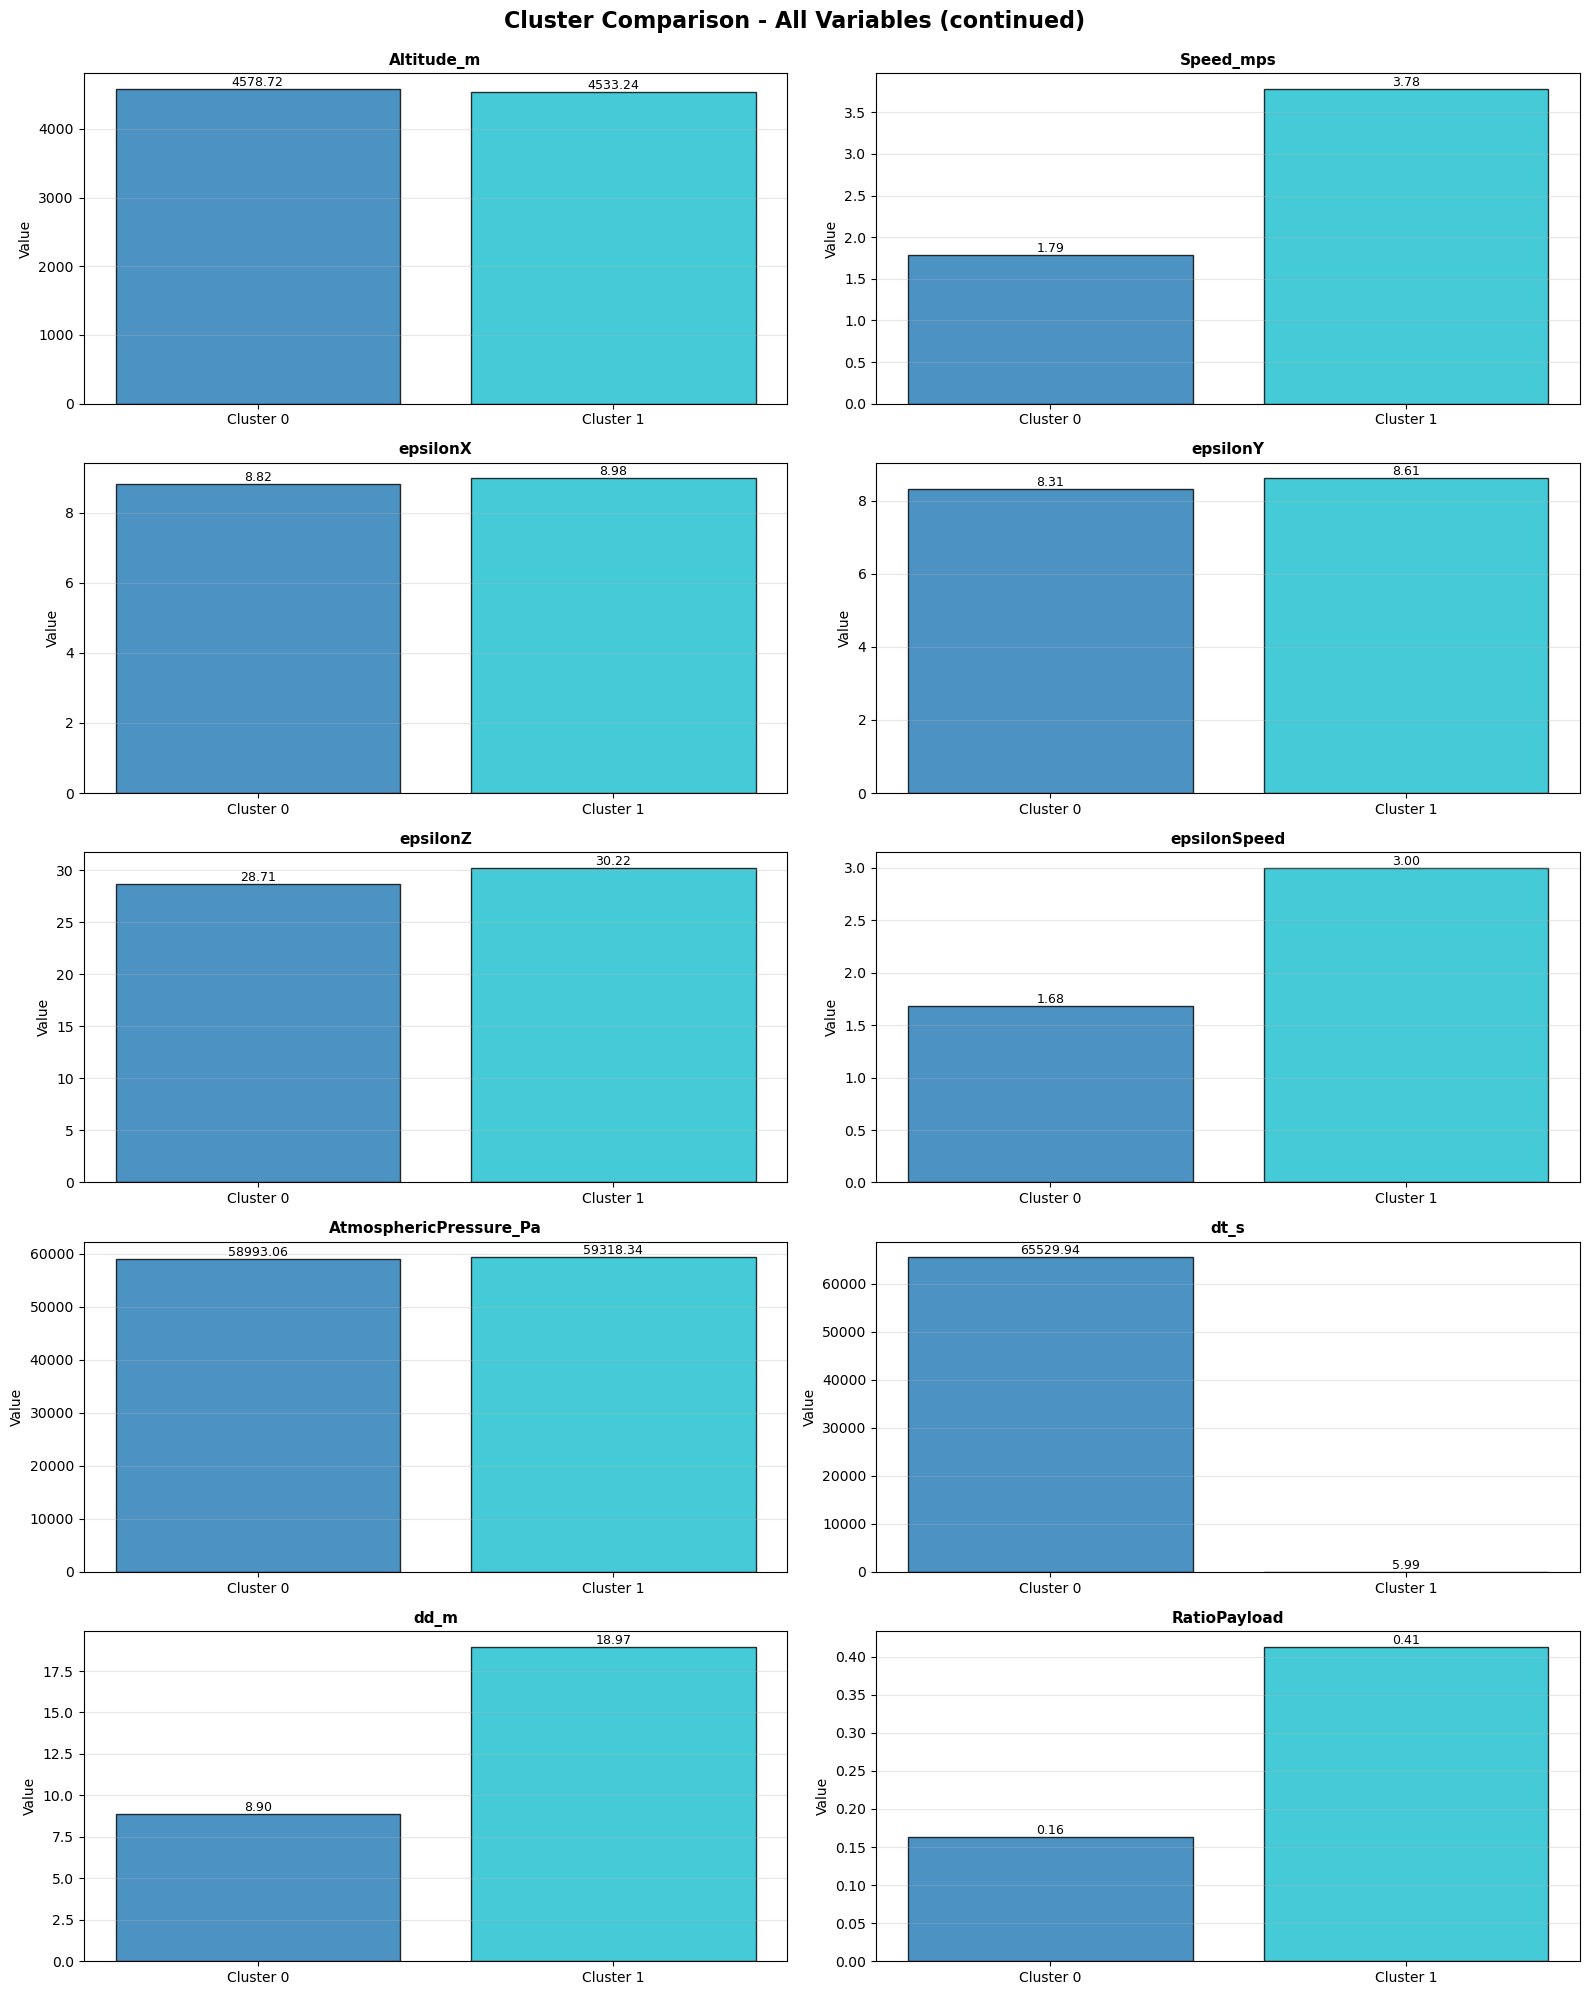

In [34]:
# Create a comprehensive bar plot comparing all variables between the two clusters
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

# Get all numeric features (excluding Cluster and Size columns)
features_to_compare = [col for col in cluster_stats.columns if col.startswith('Avg_')]

# Plot each feature
for idx, feature in enumerate(features_to_compare[:10]):  # Plot first 10 features
    ax = axes[idx]
    
    # Extract values for both clusters
    values = [cluster_stats.loc[cluster_stats['Cluster'] == 0, feature].values[0],
              cluster_stats.loc[cluster_stats['Cluster'] == 1, feature].values[0]]
    
    # Create bar plot
    bars = ax.bar(['Cluster 0', 'Cluster 1'], values, color=['#1f77b4', '#17becf'], alpha=0.8, edgecolor='black')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)
    
    # Clean up feature name for title
    feature_name = feature.replace('Avg_', '')
    ax.set_title(feature_name, fontweight='bold', fontsize=11)
    ax.set_ylabel('Value', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Cluster Comparison - All Variables', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Create second figure for remaining features
if len(features_to_compare) > 10:
    fig2, axes2 = plt.subplots(5, 2, figsize=(16, 20))
    axes2 = axes2.flatten()
    
    for idx, feature in enumerate(features_to_compare[10:20]):
        ax = axes2[idx]
        
        values = [cluster_stats.loc[cluster_stats['Cluster'] == 0, feature].values[0],
                  cluster_stats.loc[cluster_stats['Cluster'] == 1, feature].values[0]]
        
        bars = ax.bar(['Cluster 0', 'Cluster 1'], values, color=['#1f77b4', '#17becf'], alpha=0.8, edgecolor='black')
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=9)
        
        feature_name = feature.replace('Avg_', '')
        ax.set_title(feature_name, fontweight='bold', fontsize=11)
        ax.set_ylabel('Value', fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
    
    # Hide empty subplots
    for idx in range(len(features_to_compare[10:20]), 10):
        axes2[idx].set_visible(False)
    
    plt.suptitle('Cluster Comparison - All Variables (continued)', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Create third figure for any remaining features
if len(features_to_compare) > 20:
    fig3, axes3 = plt.subplots(5, 2, figsize=(16, 20))
    axes3 = axes3.flatten()
    
    for idx, feature in enumerate(features_to_compare[20:]):
        ax = axes3[idx]
        
        values = [cluster_stats.loc[cluster_stats['Cluster'] == 0, feature].values[0],
                  cluster_stats.loc[cluster_stats['Cluster'] == 1, feature].values[0]]
        
        bars = ax.bar(['Cluster 0', 'Cluster 1'], values, color=['#1f77b4', '#17becf'], alpha=0.8, edgecolor='black')
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=9)
        
        feature_name = feature.replace('Avg_', '')
        ax.set_title(feature_name, fontweight='bold', fontsize=11)
        ax.set_ylabel('Value', fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
    
    # Hide empty subplots
    for idx in range(len(features_to_compare[20:]), 10):
        axes3[idx].set_visible(False)
    
    plt.suptitle('Cluster Comparison - All Variables (continued)', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()